<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/gr_attribution_zeroshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load models

## krikri

In [ ]:
%%capture
!pip install torch transformers accelerate

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set the model ID and the device
krikri_model_id = "ilsp/Llama-Krikri-8B-Instruct"
device = "cuda" # or "cpu" if you have a powerful CPU and limited VRAM

try:
    # Loading the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(krikri_model_id)

    # Load the model
    krikri_model = AutoModelForCausalLM.from_pretrained(
        krikri_model_id,
        dtype=torch.bfloat16, # Using bfloat16 for efficiency on supported GPUs
        device_map="auto"     # Automatically distributing the model across available devices
    )
    krikri_model.to(device)

    # Prepare your instruction/prompt
    prompt = "Ποια είναι η πρωτεύουσα της Ελλάδας;" # "What is the capital of Greece?"

    # Apply the chat template for the Instruct model
    messages = [
        {"role": "user", "content": prompt}
    ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # Generate the response
    outputs = krikri_model.generate(
        input_ids,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and print the result
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)

except OSError as e:
    print(f"Error loading the model or tokenizer: {e}")
    print("This might be due to network issues or problems accessing the model files on Hugging Face.")
    print("Please try running the cell again later.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [41]:
def krikri_prompt(prompt, system_prompt, temperature=0,
    model=krikri_model):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(device)

  outputs = model.generate(
      input_ids,
      max_new_tokens=16,
      do_sample=True,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id
  )
  #response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  # In Classification Decoding Mode
  full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

  assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
  response = full_response.split(assistant_prefix)[-1].strip()

  # Finally, remove the end-of-turn token if it appears
  response = response.replace("<|eot_id|>", "").strip()

  return response

In [ ]:
import torch
import torch.nn.functional as F

def krikri_prompt(
    text,
    system_prompt,
    temperature=0.3,
    max_new_tokens=16,
    model=krikri_model,
    tokenizer=tokenizer,
    return_logprob=False,
    device=device,
):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": text},
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # Enable output_scores to compute logprobs
    outputs = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=temperature > 0,  # sample only if temperature>0
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id,
        output_scores=return_logprob,
        return_dict_in_generate=True
    )

    # Decode the full response
    full_response = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)
    assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
    response = full_response.split(assistant_prefix)[-1].strip()
    response = response.replace("<|eot_id|>", "").strip()

    if return_logprob:
        # Compute logprobs for generated tokens
        # outputs.scores has shape [num_generated_tokens, vocab_size]
        # sequences[0] has the token IDs including input
        token_ids = outputs.sequences[0][input_ids.shape[-1]:]  # generated token IDs only
        scores = outputs.scores  # list of logits for each generated token
        log_probs = []

        for i, token_id in enumerate(token_ids):
            logits = scores[i]  # [vocab_size]
            log_softmax = F.log_softmax(logits, dim=-1)
            log_probs.append(log_softmax[token_id].item())

        mean_logprob = sum(log_probs) / len(log_probs) if log_probs else None
        return response, mean_logprob

    return response

In [ ]:
def prompt_krikri(text, system_prompt, temperature=0.3, max_new_tokens=16, model=krikri_model):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": text},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(device)

  outputs = model.generate(
      input_ids,
      max_new_tokens=max_new_tokens,
      do_sample=True,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id
  )
  # In Classification Decoding Mode
  full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

  assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
  response = full_response.split(assistant_prefix)[-1].strip()

  # Finally, remove the end-of-turn token if it appears
  response = response.replace("<|eot_id|>", "").strip()

  return response

##llama3-70b

In [ ]:
%%capture
!pip install boto3
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError

In [ ]:
from google.colab import files
import json

print ('Upload the `aws.json` file: ')
files.upload()
credentials = json.load(open('aws.json'))

Upload the `aws.json` file: 


Saving aws.json to aws (1).json


In [ ]:
# Initialize the boto3 client for Bedrock
bedrock_client = boto3.client(
    'bedrock',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'],
    region_name=credentials['aws_region']
)
bedrock_client.list_foundation_models()['modelSummaries']

[{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-image-remove-background-v1:0',
  'modelId': 'stability.stable-image-remove-background-v1:0',
  'modelName': 'Stable Image Remove Background',
  'providerName': 'Stability AI',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['IMAGE'],
  'responseStreamingSupported': False,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['INFERENCE_PROFILE'],
  'modelLifecycle': {'status': 'ACTIVE'}},
 {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-image-style-guide-v1:0',
  'modelId': 'stability.stable-image-style-guide-v1:0',
  'modelName': 'Stable Image Style Guide',
  'providerName': 'Stability AI',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['IMAGE'],
  'responseStreamingSupported': False,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['INFERENCE_PROFILE'],
  'modelLifecycle': {'status': 'ACTIVE'}},
 {'modelArn': 'arn:aws:bedrock:us-

In [ ]:
# Use the native inference API to send a text message to Meta Llama 3.
# Create a Bedrock Runtime client in the AWS Region of your choice.
llama_client = boto3.client("bedrock-runtime",
                      aws_access_key_id=credentials['aws_access_key_id'],
                      aws_secret_access_key=credentials['aws_secret_access_key'],
                      region_name=credentials['aws_region'])

llama_model_id = "meta.llama3-70b-instruct-v1:0"

In [ ]:
def llama_prompt(text,
                 instruction,
                 max_len=16,
                 temperature=0.3,
                 model_id=llama_model_id,
                 client=llama_client):
  # Embed the prompt in Llama 3's instruction format.
  formatted_prompt = f"""
  <|begin_of_text|><|start_header_id|>user<|end_header_id|>
  {instruction}
  user: {text}
  <|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>
  """

  # Format the request payload using the model's native structure.
  native_request = {
      "prompt": formatted_prompt,
      "max_gen_len": max_len,
  }
  if temperature is not None:
      native_request["temperature"] = temperature

  # Convert the native request to JSON.
  request = json.dumps(native_request)

  try:
      # Invoke the model with the request.
      response = client.invoke_model(modelId=model_id, body=request)

  except (ClientError, Exception) as e:
      print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
      exit(1)

  # Decode the response body.
  model_response = json.loads(response["body"].read())

  # Extract and print the response text.
  response_text = model_response["generation"]
  return response_text

## gpt-4o-mini

In [ ]:
%%capture
!pip install --upgrade openai

In [ ]:
from google.colab import files
import json

print ('Upload the `gpt_key.json` file: ')
files.upload()
gpt_key = json.load(open('gpt_key.json'))

In [ ]:
from openai import OpenAI

GPT_API_KEY = gpt_key['gpt_api_key']
gpt_client = OpenAI(api_key=GPT_API_KEY)

gpt_model_id = "gpt-4o-mini"

In [ ]:
# model version = gpt-4o-mini-2024-07-18
# response = client.chat.completions.create(
#           model=gpt_model_id,
#           messages=[{"role": "user", "content": "Summarize this text..."}],
#         )

# print(response.model)

In [ ]:
def gpt_prompt(
    text,
    instruction,
    max_len=16,  # max output tokens
    temperature=0.3,  # deterministic output
    model_id=gpt_model_id,
    client=gpt_client,
    return_logprob=False
):
    messages = [
        {"role": "system", "content": [{"type": "text", "text": instruction}]},
        {"role": "user", "content": [{"type": "text", "text": text}]},
    ]

    kwargs = {
        "model": model_id,
        "messages": messages,
        "seed": 42,
        "max_completion_tokens": max_len,
    }

    if temperature is not None:
        kwargs["temperature"] = temperature

    # Request token logprobs if we want confidence
    if return_logprob:
        kwargs["logprobs"] = True

    response = client.chat.completions.create(**kwargs)
    output_text = response.choices[0].message.content

    if return_logprob:
        token_logprobs = [t.logprob for t in response.choices[0].logprobs.content]
        total_logprob = sum(token_logprobs)
        mean_logprob = total_logprob / len(token_logprobs)
        return output_text, mean_logprob

    return output_text

# The Dataset

In [ ]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!git clone https://github.com/greek-nlp/benchmark.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

In [ ]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.drop_duplicates(inplace=True, subset=['text'])
barzokas = barzokas[barzokas.status=='parsable']
barzokas = barzokas[barzokas.tokensCount>1000]

Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


## openbook

['Θανάσης Τριαρίδης', 'Γιάννης Αντάμης', 'Κώστας Βουλαζέρης', 'Πάνος Κολιόπουλος', 'Δημήτρης Τζουβάλης', 'Plato', 'Ράνια Συνοδινού', 'Γιώργος Σ. Κόκκινος', 'Πάνος Α. Ζέρβας', 'Ευρυδίκη Αμανατίδου', 'Κατερίνα Καζολέα', 'Τέος Ρόμβος', 'Χάρης Γαντζούδης', 'Φρίντα Κριτσωτάκη', 'Πασχάλης Παπαβασιλείου', 'Βασίλειος Κάππας', 'Αύγουστος Κορτώ']


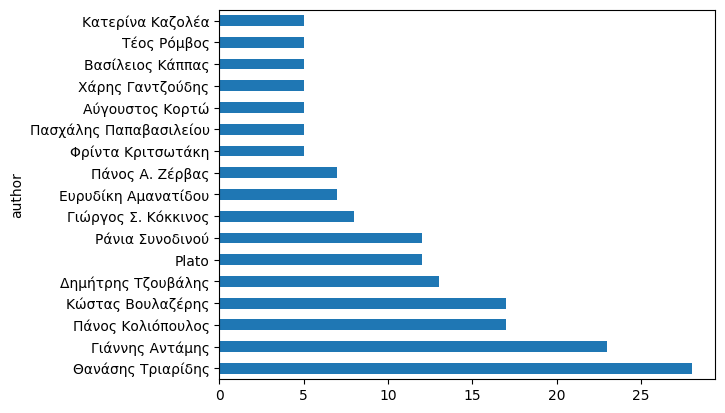

In [ ]:
authors = barzokas.author.value_counts()[:17].index.tolist()
barzokas_pop = barzokas[barzokas.author.isin(authors)]
print(authors)
barzokas_pop.author.value_counts().plot(kind='barh');

In [ ]:
import random

def get_random_middle_excerpt(text, length=1000, offset_range=10000):
  """
  Returns an excerpt by choosing a random start point within
  a certain range around the absolute middle of the text.
  """
  text_length = len(text)

  # 1. Find the ideal middle start (if we were taking the fixed middle)
  middle_start_ideal = text_length // 2 - length // 2

  # 2. Define the range for the random starting point
  # The starting point will be between:
  #   max(0, middle_start_ideal - offset_range)
  # and
  #   min(text_length - length, middle_start_ideal + offset_range)

  # Ensure the start index is not negative and the excerpt fits in the text
  min_start = max(0, middle_start_ideal - offset_range // 2)
  max_start = min(text_length - length, middle_start_ideal + offset_range // 2)

  # Handle cases where the text is too short
  if min_start >= max_start:
      return text[:length] # Just return the first part or the whole text if shorter

  # 3. Pick a random starting index
  start_index = random.randint(min_start, max_start)

  # 4. Extract the excerpt
  return text[start_index : start_index + length]

# To get multiple diverse, yet middle-focused samples:
# sample1 = get_random_middle_excerpt(text)
# sample2 = get_random_middle_excerpt(text)

In [ ]:
%%capture
# Loop 10 times to create 10 new columns
for i in range(1, 11):
  barzokas_pop[f'excerpt_{i}'] = barzokas_pop.text.apply(get_random_middle_excerpt)

In [ ]:
barzokas_pop.to_csv('barzokas_10excerpts.csv.gz', compression='gzip')

### Exploratory

In [ ]:
barzokas_pop.sample()

,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,...,excerpt_1,excerpt_2,excerpt_3,excerpt_4,excerpt_5,excerpt_6,excerpt_7,excerpt_8,excerpt_9,excerpt_10
975,openBook1393,"Τιμόκλη, φέτος να σμίγουμε ξανά",Πάνος Α. Ζέρβας,Διήγημα,2016,NaN,"Τιμόκλη, φέτος να σμίγουμε ξανά.pdf",https://www.openbook.gr/timokli-fetos-na-smigo...,http://bit.ly/2Tkl4ks,NaN,...,ο μοναχόςπρέπει να αποφεύγει κάθε δημόσια...,κά η Ηγουμένηπρέπει να αναγνωρίζει ότι θα δώσε...,"χή, την μετάνοια και να δοξάζετε τον Θεό»«Αδια...","ίστη και ζήλο,γεμάτη πνευματικά χαρίσματα…»«...",ναστροφή με την πόρνηγυναίκα: Απέλιπες την...,είναι φοβερόνα διασωθεί κανείς από το πέλαγος ...,ένηται αυτή έμμισθος η υπακοή. Κάθε δε α...,αιπρέπει να φροντίζει να μη εισαγάγει τον κόσμ...,"λύπης ή εξ ανάγκης,ίνα γένηται αυτή έμμισθο...",την αξία Ηγουμένη σας Χρυσοστόμη έναν πν...


In [ ]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Use TF-IDF for vectorization
vectorizer = TfidfVectorizer()

excerpt_columns = [f'excerpt_{i}' for i in range(1, 11)]
overlap_data_cosine = []

for index, row in barzokas_pop.iterrows():
    row_data = row[excerpt_columns].tolist()

    # Handle cases with empty strings or very short texts that might cause errors in TF-IDF
    # Filter out None or empty strings before vectorization
    row_data_filtered = [text for text in row_data if isinstance(text, str) and text.strip()]

    if len(row_data_filtered) < 2:
        # Not enough valid excerpts to calculate pairwise similarity
        row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}
    else:
        try:
            # Fit and transform the excerpts
            tfidf_matrix = vectorizer.fit_transform(row_data_filtered)

            # Calculate cosine similarity
            cosine_sim_matrix = cosine_similarity(tfidf_matrix)

            # Map the results back to original excerpt columns
            # Create a mapping from filtered indices back to original excerpt column names
            filtered_to_original_col = {i: col for i, col in enumerate(excerpt_columns) if row_data[excerpt_columns.index(col)] in row_data_filtered}

            row_overlap = {}
            for i, j in itertools.combinations(range(len(row_data_filtered)), 2):
                original_col1 = filtered_to_original_col[i]
                original_col2 = filtered_to_original_col[j]
                row_overlap[f'{original_col1}_{original_col2}_overlap_cosine'] = cosine_sim_matrix[i, j]

            # Fill in 0.0 for pairs that included filtered out excerpts
            all_pairs = itertools.combinations(excerpt_columns, 2)
            for col1, col2 in all_pairs:
                if f'{col1}_{col2}_overlap_cosine' not in row_overlap:
                     row_overlap[f'{col1}_{col2}_overlap_cosine'] = 0.0


        except ValueError as e:
            print(f"Could not process row {index}: {e}")
            row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}


    overlap_data_cosine.append(row_overlap)


overlap_df_cosine = pd.DataFrame(overlap_data_cosine, index=barzokas_pop.index)

# Display the first few rows of the overlap DataFrame
display(overlap_df_cosine.head())

,excerpt_1_excerpt_2_overlap_cosine,excerpt_1_excerpt_3_overlap_cosine,excerpt_1_excerpt_4_overlap_cosine,excerpt_1_excerpt_5_overlap_cosine,excerpt_1_excerpt_6_overlap_cosine,excerpt_1_excerpt_7_overlap_cosine,excerpt_1_excerpt_8_overlap_cosine,excerpt_1_excerpt_9_overlap_cosine,excerpt_1_excerpt_10_overlap_cosine,excerpt_2_excerpt_3_overlap_cosine,...,excerpt_6_excerpt_7_overlap_cosine,excerpt_6_excerpt_8_overlap_cosine,excerpt_6_excerpt_9_overlap_cosine,excerpt_6_excerpt_10_overlap_cosine,excerpt_7_excerpt_8_overlap_cosine,excerpt_7_excerpt_9_overlap_cosine,excerpt_7_excerpt_10_overlap_cosine,excerpt_8_excerpt_9_overlap_cosine,excerpt_8_excerpt_10_overlap_cosine,excerpt_9_excerpt_10_overlap_cosine
537,0.311619,0.212097,0.232661,0.147748,0.277490,0.179719,0.240015,0.235151,0.218422,0.248619,...,0.174976,0.263877,0.272715,0.234968,0.236477,0.207736,0.223907,0.283674,0.238305,0.279771
541,0.254827,0.248696,0.627691,0.273974,0.259370,0.266920,0.222999,0.406324,0.668865,0.251994,...,0.921301,0.212932,0.215091,0.190877,0.233166,0.227632,0.176779,0.216434,0.217108,0.326702
545,0.275108,0.343141,0.228577,0.333074,0.269800,0.215511,0.304553,0.351401,0.353529,0.314703,...,0.264885,0.248295,0.271959,0.306867,0.233529,0.272991,0.272811,0.330996,0.310982,0.368344
552,0.202411,0.202704,0.165385,0.131428,0.674082,0.467137,0.158614,0.203798,0.259366,0.307257,...,0.222053,0.178907,0.157478,0.215744,0.160874,0.243878,0.311676,0.233611,0.190481,0.242669
561,0.193854,0.181370,0.928689,0.237305,0.502246,0.241045,0.215358,0.229826,0.272320,0.246749,...,0.220578,0.248066,0.247556,0.560299,0.215370,0.279025,0.718325,0.202920,0.242075,0.306536


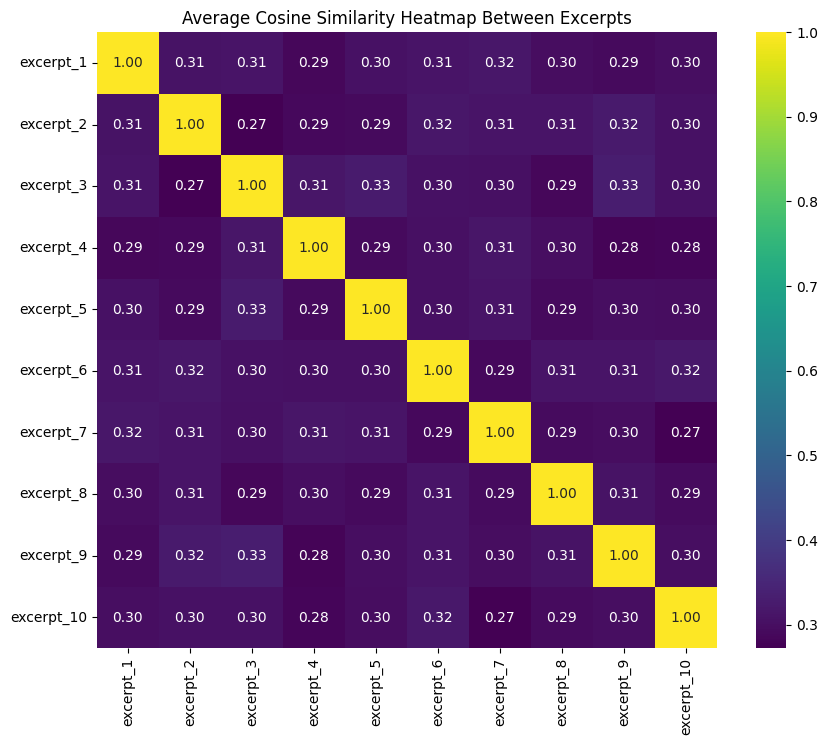

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average overlap for each pair of excerpts from the cosine similarity DataFrame
average_overlap_series_cosine = overlap_df_cosine.mean()

# Reshape the series into a square DataFrame for the heatmap
overlap_matrix_cosine = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))

for col_name, avg_overlap in average_overlap_series_cosine.items():
    # Extract excerpt numbers from the column name (e.g., 'excerpt_1_excerpt_2_overlap_cosine')
    parts = col_name.split('_')
    i = int(parts[1])
    j = int(parts[3])
    overlap_matrix_cosine.loc[i, j] = avg_overlap
    overlap_matrix_cosine.loc[j, i] = avg_overlap # Heatmap is symmetric

# Fill the diagonal with 1.0 as an excerpt has perfect overlap with itself
for i in range(1, 11):
    overlap_matrix_cosine.loc[i, i] = 1.0


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix_cosine, annot=True, cmap='viridis', fmt=".2f", xticklabels=[f'excerpt_{i}' for i in range(1, 11)], yticklabels=[f'excerpt_{i}' for i in range(1, 11)])
plt.title('Average Cosine Similarity Heatmap Between Excerpts')
plt.show()

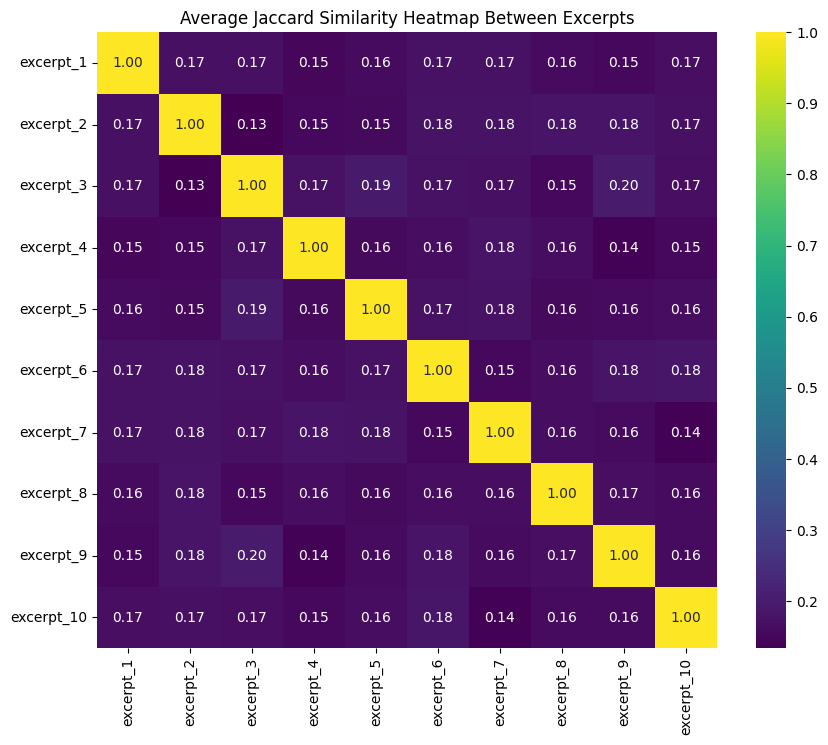

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average overlap for each pair of excerpts
# The columns in overlap_df are already in the format 'excerpt_i_excerpt_j_overlap'
# We can directly calculate the mean of each column
average_overlap_series = overlap_df.mean()

# Reshape the series into a square DataFrame for the heatmap
# We need to extract the excerpt numbers from the column names
overlap_matrix = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))

for col_name, avg_overlap in average_overlap_series.items():
    # Extract excerpt numbers from the column name (e.g., 'excerpt_1_excerpt_2_overlap')
    parts = col_name.split('_')
    i = int(parts[1])
    j = int(parts[3])
    overlap_matrix.loc[i, j] = avg_overlap
    overlap_matrix.loc[j, i] = avg_overlap # Heatmap is symmetric

# Fill the diagonal with 1.0 as an excerpt has perfect overlap with itself
for i in range(1, 11):
    overlap_matrix.loc[i, i] = 1.0


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, cmap='viridis', fmt=".2f", xticklabels=[f'excerpt_{i}' for i in range(1, 11)], yticklabels=[f'excerpt_{i}' for i in range(1, 11)])
plt.title('Average Jaccard Similarity Heatmap Between Excerpts')
plt.show()

### Load and explore

In [ ]:
!gdown 17Ks0Q8GFsunj5w3PoHwcG1vTm_bfLhpL

Downloading...
From: https://drive.google.com/uc?id=17Ks0Q8GFsunj5w3PoHwcG1vTm_bfLhpL
To: /content/barzokas_10excerpts.csv.gz
100% 19.7M/19.7M [00:00<00:00, 69.4MB/s]


In [ ]:
import pandas as pd
barzokas_pop = pd.read_csv('barzokas_10excerpts.csv.gz', index_col=0)
pop_authors = barzokas_pop.author.value_counts().index.tolist()
pop_authors

['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Plato',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

In [ ]:
regex_pattern = '|'.join(pop_authors)
for i in range(1, 11):
  barzokas_pop[f'excerpt_{i}'] = barzokas_pop[f'excerpt_{i}'].str.replace(regex_pattern, '', regex=True, case=True)

In [ ]:
# sanity check
barzokas_pop['excerpt_1'].str.contains(regex_pattern, case=True, na=False).sum()

np.int64(0)

In [ ]:
barzokas_pop.to_csv('barzokas_10ex_anonymized.csv.gz', compression='gzip')

## gutenberg

In [ ]:
import re

gutenberg = barzokas[barzokas.publisher=='project_gutenberg']
gutenberg_authors = ['Karkavitsas, Andreas', 'Souris, Georgios', 'Chatzopoulos, Kostantinos', 'Nirvanas, Paulos', 'Polemes, Ioannes', 'Papantoniou, Zacharias L.', 'Eftaliotis, Argyris', 'Dragoumes, Ion', 'Golfis, Rigas', 'Delta, Penelope Stephanou', 'Christovasilis, Christos']
gutenberg_dataset = gutenberg[gutenberg.author.isin(gutenberg_authors)].copy()
# for i in range(1, 11):
#   gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.text.apply(lambda x: get_random_middle_excerpt(x, run=i))
for i in range(1, 11):
  gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.text.apply(lambda x: get_random_middle_excerpt(x))

def remove_author_from_excerpt(excerpt, author):
    # Create a regex pattern to match the author's name and surname in the format "Surname, Name"
    # This pattern accounts for potential variations in spacing.
    pattern = re.compile(r'\s*' + re.escape(author.split(',')[1].strip()) + r'\s+' + re.escape(author.split(',')[0].strip()) + r'\s*', re.IGNORECASE)
    return re.sub(pattern, '', excerpt)

for i in range(1, 11):
    gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.apply(
        lambda row: remove_author_from_excerpt(row[f'excerpt_{i}'], row['author']),
        axis=1
    )

In [ ]:
gutenberg_dataset.to_csv('gutenberg_10ex_anonymized.csv.gz', compression='gzip')

### Exploratory

In [ ]:

import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Use TF-IDF for vectorization
vectorizer = TfidfVectorizer()

excerpt_columns = [f'excerpt_{i}' for i in range(1, 11)]
overlap_data_cosine = []

for index, row in gutenberg_dataset.iterrows():
    row_data = row[excerpt_columns].tolist()

    # Handle cases with empty strings or very short texts that might cause errors in TF-IDF
    # Filter out None or empty strings before vectorization
    row_data_filtered = [text for text in row_data if isinstance(text, str) and text.strip()]

    if len(row_data_filtered) < 2:
        # Not enough valid excerpts to calculate pairwise similarity
        row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}
    else:
        try:
            # Fit and transform the excerpts
            tfidf_matrix = vectorizer.fit_transform(row_data_filtered)

            # Calculate cosine similarity
            cosine_sim_matrix = cosine_similarity(tfidf_matrix)

            # Map the results back to original excerpt columns
            # Create a mapping from filtered indices back to original excerpt column names
            filtered_to_original_col = {i: col for i, col in enumerate(excerpt_columns) if row_data[excerpt_columns.index(col)] in row_data_filtered}

            row_overlap = {}
            for i, j in itertools.combinations(range(len(row_data_filtered)), 2):
                original_col1 = filtered_to_original_col[i]
                original_col2 = filtered_to_original_col[j]
                row_overlap[f'{original_col1}_{original_col2}_overlap_cosine'] = cosine_sim_matrix[i, j]

            # Fill in 0.0 for pairs that included filtered out excerpts
            all_pairs = itertools.combinations(excerpt_columns, 2)
            for col1, col2 in all_pairs:
                if f'{col1}_{col2}_overlap_cosine' not in row_overlap:
                     row_overlap[f'{col1}_{col2}_overlap_cosine'] = 0.0


        except ValueError as e:
            print(f"Could not process row {index}: {e}")
            row_overlap = {f'{col1}_{col2}_overlap_cosine': 0.0 for col1, col2 in itertools.combinations(excerpt_columns, 2)}


    overlap_data_cosine.append(row_overlap)


overlap_df_cosine = pd.DataFrame(overlap_data_cosine, index=gutenberg_dataset.index)

# Display the first few rows of the overlap DataFrame
display(overlap_df_cosine.head())

,excerpt_1_excerpt_2_overlap_cosine,excerpt_1_excerpt_3_overlap_cosine,excerpt_1_excerpt_4_overlap_cosine,excerpt_1_excerpt_5_overlap_cosine,excerpt_1_excerpt_6_overlap_cosine,excerpt_1_excerpt_7_overlap_cosine,excerpt_1_excerpt_8_overlap_cosine,excerpt_1_excerpt_9_overlap_cosine,excerpt_1_excerpt_10_overlap_cosine,excerpt_2_excerpt_3_overlap_cosine,...,excerpt_6_excerpt_7_overlap_cosine,excerpt_6_excerpt_8_overlap_cosine,excerpt_6_excerpt_9_overlap_cosine,excerpt_6_excerpt_10_overlap_cosine,excerpt_7_excerpt_8_overlap_cosine,excerpt_7_excerpt_9_overlap_cosine,excerpt_7_excerpt_10_overlap_cosine,excerpt_8_excerpt_9_overlap_cosine,excerpt_8_excerpt_10_overlap_cosine,excerpt_9_excerpt_10_overlap_cosine
0,0.182475,0.226444,0.246423,0.643215,0.195663,0.201826,0.179033,0.215184,0.572929,0.179619,...,0.162011,0.793969,0.174343,0.165533,0.148573,0.138186,0.177722,0.158928,0.158529,0.327916
1,0.289238,0.353342,0.195873,0.826181,0.359232,0.154696,0.259061,0.298045,0.303437,0.280781,...,0.206441,0.254189,0.692691,0.308460,0.133764,0.227217,0.173628,0.214769,0.247228,0.240485
2,0.109128,0.153033,0.150685,0.296836,0.159966,0.144675,0.159349,0.129376,0.176491,0.253979,...,0.243507,0.318988,0.251280,0.294147,0.242383,0.642505,0.246042,0.247601,0.315447,0.235186
3,0.234811,0.216235,0.228459,0.449806,0.202781,0.217805,0.230547,0.203608,0.209139,0.775241,...,0.212646,0.194896,0.181479,0.176484,0.183779,0.216357,0.204498,0.184284,0.179983,0.887739
4,0.274621,0.257223,0.248566,0.176568,0.280303,0.244967,0.350173,0.307776,0.936777,0.266069,...,0.252592,0.213223,0.332196,0.342531,0.248205,0.227476,0.240446,0.237093,0.293316,0.292687


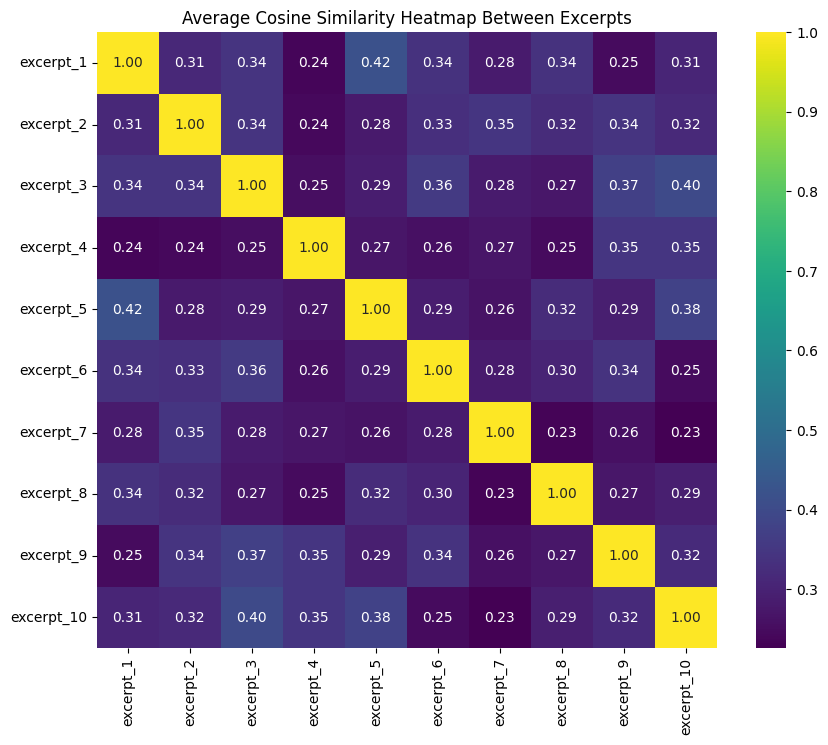

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average overlap for each pair of excerpts from the cosine similarity DataFrame
average_overlap_series_cosine = overlap_df_cosine.mean()

# Reshape the series into a square DataFrame for the heatmap
overlap_matrix_cosine = pd.DataFrame(0.0, index=range(1, 11), columns=range(1, 11))

for col_name, avg_overlap in average_overlap_series_cosine.items():
    # Extract excerpt numbers from the column name (e.g., 'excerpt_1_excerpt_2_overlap_cosine')
    parts = col_name.split('_')
    i = int(parts[1])
    j = int(parts[3])
    overlap_matrix_cosine.loc[i, j] = avg_overlap
    overlap_matrix_cosine.loc[j, i] = avg_overlap # Heatmap is symmetric

# Fill the diagonal with 1.0 as an excerpt has perfect overlap with itself
for i in range(1, 11):
    overlap_matrix_cosine.loc[i, i] = 1.0


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix_cosine, annot=True, cmap='viridis', fmt=".2f", xticklabels=[f'excerpt_{i}' for i in range(1, 11)], yticklabels=[f'excerpt_{i}' for i in range(1, 11)])
plt.title('Average Cosine Similarity Heatmap Between Excerpts')
plt.show()

# Create test dataset

## Gutenberg

In [ ]:
!gdown 1I398w-n0FueM4aVi6i-vFX8_MS-yMR6C

Downloading...
From: https://drive.google.com/uc?id=1I398w-n0FueM4aVi6i-vFX8_MS-yMR6C
To: /content/gutenberg_10ex_anonymized.csv.gz
100% 1.70M/1.70M [00:00<00:00, 158MB/s]


In [ ]:
gutenberg_dataset = pd.read_csv('gutenberg_10ex_anonymized.csv.gz', compression='gzip')

In [ ]:
author_list = '\n'.join(gutenberg_dataset.author.unique())
instruct = (
    "You are given an excerpt from a Greek book. "
    f"Choose the author from the following list:\n{author_list}.\n"
    "Return only the exact name of the author as written in the list, nothing else."
)
# get output's mean logprob
temp = 0
return_logprob = True
print(instruct)

You are given an excerpt from a Greek book. Choose the author from the following list:
Karkavitsas, Andreas
Eftaliotis, Argyris
Souris, Georgios
Chatzopoulos, Kostantinos
Dragoumes, Ion
Delta, Penelope Stephanou
Nirvanas, Paulos
Papantoniou, Zacharias L.
Christovasilis, Christos
Polemes, Ioannes
Golfis, Rigas.
Return only the exact name of the author as written in the list, nothing else.


In [ ]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
    results = [
        gpt_prompt(t, instruct, temperature=temp, return_logprob=return_logprob)
        for t in gutenberg_dataset[f'excerpt_{i}'].values
    ]

    # Unpack into two columns
    gutenberg_dataset[f'gpt_{i}_author'] = [r[0] for r in results]      # predicted author
    gutenberg_dataset[f'gpt_{i}_logprob'] = [round(r[1], 3) for r in results]     # mean log probability
gutenberg_dataset.sample()

  0%|          | 0/10 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,gpt_6_author,gpt_6_logprob,gpt_7_author,gpt_7_logprob,gpt_8_author,gpt_8_logprob,gpt_9_author,gpt_9_logprob,gpt_10_author,gpt_10_logprob
0,157,PG31865,Λόγια της Πλώρης: Θαλασσινά Διηγήματα,"Karkavitsas, Andreas",NaN,1899,NaN,NaN,NaN,NaN,...,"Karkavitsas, Andreas",-0.05,"Karkavitsas, Andreas",-0.024,"Karkavitsas, Andreas",-0.022,"Karkavitsas, Andreas",-0.012,"Karkavitsas, Andreas",-0.004


In [ ]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
  gutenberg_dataset[f'llama_{i}_author'] = [llama_prompt(t, instruct, temperature=temp) for t in tqdm(gutenberg_dataset[f'excerpt_{i}'].values)]

gutenberg_dataset.sample()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,llama_1_author,llama_2_author,llama_3_author,llama_4_author,llama_5_author,llama_6_author,llama_7_author,llama_8_author,llama_9_author,llama_10_author
19,218,PG20175,Φθινόπωρο,"Chatzopoulos, Kostantinos",NaN,2006,NaN,NaN,NaN,NaN,...,Penelope Delta,"Delta, Penelope Stephanou",Penelope Delta,Penelope Delta,"Delta, Penelope Stephanou",Penelope Delta,Penelope Delta,Andreas Embirikos,"Delta, Penelope Stephanou",Penelope Delta


In [ ]:
gutenberg_dataset.to_csv('gutenberg_author_attr_res.csv.gz', index=False, compression='gzip')

In [ ]:
import pandas as pd

# Columns to keep from original dataframe
base_cols = ['Unnamed: 0', 'id', 'title', 'author', 'type', 'publishedYear', 'isbn',
             'filename', 'postUrl', 'attachmentUrl', 'authorYearOfBirth',
             'authorYearOfDeath', 'tokensCount', 'status', 'publisher']

rows = []

for i in range(1, 11):
    excerpt_col = f'excerpt_{i}'
    gpt_author_col = f'gpt_{i}_author'
    gpt_logprob_col = f'gpt_{i}_logprob'
    llama_author_col = f'llama_{i}_author'

    for idx, row in gutenberg_dataset.iterrows():
        gpt_found = str(row['author']).strip().split(',')[0] in str(row[gpt_author_col]).strip()
        llama_found = str(row['author']).strip().split(',')[0] in str(row[llama_author_col]).strip()

        if gpt_found or llama_found:
            rows.append({
                **row[base_cols].to_dict(),
                'excerpt_num': i,
                'gpt_found': gpt_found,
                'llama_found': llama_found,
                'gpt_logprob': row[gpt_logprob_col],
                'excerpt_text': row[excerpt_col],
                'gpt_author': row[gpt_author_col],
                'llama_author': row[llama_author_col],
            })

# Create the filtered dataframe
test_gb_df = pd.DataFrame(rows)

# Optional: reorder columns nicely
cols_order = base_cols + ['excerpt_num', 'excerpt_text', 'gpt_found', 'llama_found', 'gpt_author', 'gpt_logprob', 'llama_author']
test_gb_df = test_gb_df[cols_order]
test_gb_df[['author','excerpt_num','gpt_found', 'llama_found',
       'gpt_author', 'llama_author', 'gpt_logprob']].head()

,author,excerpt_num,gpt_found,llama_found,gpt_author,llama_author,gpt_logprob
0,"Karkavitsas, Andreas",1,True,False,"Karkavitsas, Andreas",Penelope Delta,-0.027
1,"Karkavitsas, Andreas",1,True,False,"Karkavitsas, Andreas",Penelope Delta,-0.001
2,"Dragoumes, Ion",1,True,True,"Dragoumes, Ion",Ion Dragoumes,-0.002
3,"Karkavitsas, Andreas",1,True,False,"Karkavitsas, Andreas","Papantoniou, Zacharias L.",-0.021
4,"Chatzopoulos, Kostantinos",1,True,False,"Chatzopoulos, Kostantinos",Penelope Delta,-0.013


In [ ]:
test_gb_df.to_csv('gutenberg_test_excerpts.csv.gz', index=False, compression='gzip')

## Openbook

In [ ]:
!gdown 1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz

Downloading...
From: https://drive.google.com/uc?id=1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz
To: /content/barzokas_10ex_anonymized.csv.gz
100% 19.7M/19.7M [00:00<00:00, 143MB/s]


In [ ]:
import re

openbook_authors = ['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

openbook_dataset = pd.read_csv('barzokas_10ex_anonymized.csv.gz', compression='gzip')
openbook_dataset = openbook_dataset.loc[(openbook_dataset.publisher=='openbook') & (openbook_dataset.author.isin(openbook_authors))].copy()

def remove_author_from_excerpt(excerpt, author):
    """
    Remove all parts of the author's name from the text.
    Works for any order and middle names/initials.
    """
    # Split the author's name into parts
    parts = author.strip().split()
    if not parts:
        return excerpt

    # Escape each part for regex
    parts_escaped = [re.escape(p) for p in parts]

    # Create a regex that matches any of the parts
    pattern = re.compile(r'\b(?:' + '|'.join(parts_escaped) + r')\b', re.IGNORECASE)

    # Remove all matches
    return re.sub(pattern, '', excerpt)


for i in range(1, 11):
    openbook_dataset[f'excerpt_{i}'] = openbook_dataset.apply(
        lambda row: remove_author_from_excerpt(row[f'excerpt_{i}'], row['author']),
        axis=1
    )

In [ ]:
author_list = ',\n'.join(openbook_dataset.author.unique())
instruct = (
    "You are given an excerpt from a Greek book. "
    f"Choose the author from the following list:\n{author_list}.\n"
    "Return only the exact name of the author as written in the list, nothing else."
)
# get output's mean logprob
temp = 0
return_logprob = True
print(instruct)

You are given an excerpt from a Greek book. Choose the author from the following list:
Φρίντα Κριτσωτάκη,
Κώστας Βουλαζέρης,
Ράνια Συνοδινού,
Θανάσης Τριαρίδης,
Πασχάλης Παπαβασιλείου,
Πάνος Κολιόπουλος,
Γιάννης Αντάμης,
Αύγουστος Κορτώ,
Χάρης Γαντζούδης,
Πάνος Α. Ζέρβας,
Βασίλειος Κάππας,
Ευρυδίκη Αμανατίδου,
Τέος Ρόμβος,
Γιώργος Σ. Κόκκινος,
Κατερίνα Καζολέα,
Δημήτρης Τζουβάλης.
Return only the exact name of the author as written in the list, nothing else.


In [ ]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
    results = [
        gpt_prompt(t, instruct, temperature=temp, return_logprob=return_logprob)
        for t in openbook_dataset[f'excerpt_{i}'].values
    ]

    # Unpack into two columns
    openbook_dataset[f'gpt_{i}_author'] = [r[0] for r in results]      # predicted author
    openbook_dataset[f'gpt_{i}_logprob'] = [round(r[1], 3) for r in results]     # mean log probability
openbook_dataset.sample()

  0%|          | 0/9 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,gpt_6_author,gpt_6_logprob,gpt_7_author,gpt_7_logprob,gpt_8_author,gpt_8_logprob,gpt_9_author,gpt_9_logprob,gpt_10_author,gpt_10_logprob
120,1286,openBook1408,Νυχτανθοί και Νεράιδες,Δημήτρης Τζουβάλης,Διήγημα,2000,NaN,Νυχτανθοί και Νεράιδες.pdf,https://www.openbook.gr/nyxtanthoi-kai-neraides/,http://bit.ly/2Fg8W0c,...,Θανάσης Τριαρίδης,-0.033,Θανάσης Τριαρίδης,-0.086,Αύγουστος Κορτώ,-0.094,Θανάσης Τριαρίδης,-0.058,Θανάσης Τριαρίδης,-0.051


In [ ]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
  openbook_dataset[f'llama_{i}_author'] = [llama_prompt(t, instruct, temperature=temp) for t in tqdm(openbook_dataset[f'excerpt_{i}'].values)]

openbook_dataset.sample()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,llama_1_author,llama_2_author,llama_3_author,llama_4_author,llama_5_author,llama_6_author,llama_7_author,llama_8_author,llama_9_author,llama_10_author
44,831,openBook1484,Οι μυθοσυλλέκτες,Γιάννης Αντάμης,Δοκίμιο,2016,NaN,Οι μυθοσυλλέκτες.pdf,https://www.openbook.gr/oi-mythosyllektes/,http://bit.ly/2qNE9SU,...,Κατερίνα Καζολέα,Όλγα Αυγουστίνου,Φρίντα Κριτσωτάκη,Χαράλαμπος Γιαννακόπουλος,Γιώργος Σ. Κόκκινος,Κατερίνα Καζολέα,Γιώργος Σ. Κόκκινος,Γιώργος Σ. Κόκκινος,Κώστας Βουλαζέρης,None of the above. The author of the excerpt ...


In [ ]:
openbook_dataset.to_csv('openbook_author_attr_res.csv.gz', index=False, compression='gzip')


In [ ]:
import pandas as pd

# Columns to keep from original dataframe
base_cols = ['Unnamed: 0', 'id', 'title', 'author', 'type', 'publishedYear', 'isbn',
             'filename', 'postUrl', 'attachmentUrl', 'authorYearOfBirth',
             'authorYearOfDeath', 'tokensCount', 'status', 'publisher']

rows = []

for i in range(1, 11):
    excerpt_col = f'excerpt_{i}'
    gpt_author_col = f'gpt_{i}_author'
    gpt_logprob_col = f'gpt_{i}_logprob'
    llama_author_col = f'llama_{i}_author'

    for idx, row in openbook_dataset.iterrows():
        gpt_found = str(row['author']).strip().split(',')[0] in str(row[gpt_author_col]).strip()
        llama_found = str(row['author']).strip().split(',')[0] in str(row[llama_author_col]).strip()

        if gpt_found or llama_found:
            rows.append({
                **row[base_cols].to_dict(),
                'excerpt_num': i,
                'gpt_found': gpt_found,
                'llama_found': llama_found,
                'gpt_logprob': row[gpt_logprob_col],
                'excerpt_text': row[excerpt_col],
                'gpt_author': row[gpt_author_col],
                'llama_author': row[llama_author_col],
            })

# Create the filtered dataframe
test_ob_df = pd.DataFrame(rows)

# Optional: reorder columns nicely
cols_order = base_cols + ['excerpt_num', 'excerpt_text', 'gpt_found', 'llama_found', 'gpt_author', 'gpt_logprob', 'llama_author']
test_ob_df = test_ob_df[cols_order]
test_ob_df[['author','excerpt_num','gpt_found', 'llama_found',
       'gpt_author', 'llama_author', 'gpt_logprob']].head()

,author,excerpt_num,gpt_found,llama_found,gpt_author,llama_author,gpt_logprob
0,Θανάσης Τριαρίδης,1,True,False,Θανάσης Τριαρίδης,Ράνια Συνοδινού,-0.022
1,Θανάσης Τριαρίδης,1,True,True,Θανάσης Τριαρίδης,Θανάσης Τριαρίδης,-0.000
2,Αύγουστος Κορτώ,1,True,False,Αύγουστος Κορτώ,Φρίντα Κριτσωτάκη,-0.084
3,Πασχάλης Παπαβασιλείου,1,True,True,Πασχάλης Παπαβασιλείου,Πασχάλης Παπαβασιλείου,-0.000
4,Θανάσης Τριαρίδης,1,True,False,Θανάσης Τριαρίδης,Γιώργος Σ. Κόκκινος,-0.014


In [ ]:
test_ob_df.shape

(422, 22)

In [ ]:
test_ob_df.to_csv('openbook_test_excerpts.csv.gz', index=False, compression='gzip')

## Run with krikri
To generate test dataset, run the load krikri model and then the code in this section

### Gutenberg

In [42]:
!gdown 1I398w-n0FueM4aVi6i-vFX8_MS-yMR6C
!gdown 1V-Q5mPC3pbca2tfGL-nrs0gbN_BTPtlU

Downloading...
From: https://drive.google.com/uc?id=1I398w-n0FueM4aVi6i-vFX8_MS-yMR6C
To: /content/gutenberg_10ex_anonymized.csv.gz
100% 1.70M/1.70M [00:00<00:00, 176MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V-Q5mPC3pbca2tfGL-nrs0gbN_BTPtlU
To: /content/gutenberg_author_attr_res.csv.gz
100% 1.70M/1.70M [00:00<00:00, 190MB/s]


In [43]:
gutenberg_dataset = pd.read_csv('gutenberg_10ex_anonymized.csv.gz', compression='gzip')

In [46]:
author_list = '\n'.join(gutenberg_dataset.author.unique())
instruct = (
    "You are given an excerpt from a Greek book. "
    f"Choose the author from the following list:\n{author_list}.\n"
    "Return only the exact name of the author as written in the list, nothing else."
)
# get output's mean logprob
temp = 0.1
print(instruct)

You are given an excerpt from a Greek book. Choose the author from the following list:
Karkavitsas, Andreas
Eftaliotis, Argyris
Souris, Georgios
Chatzopoulos, Kostantinos
Dragoumes, Ion
Delta, Penelope Stephanou
Nirvanas, Paulos
Papantoniou, Zacharias L.
Christovasilis, Christos
Polemes, Ioannes
Golfis, Rigas.
Return only the exact name of the author as written in the list, nothing else.


In [52]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
    gutenberg_dataset[f'krikri_{i}_author'] = [
        krikri_prompt(t, instruct, temperature=temp)
        for t in gutenberg_dataset[f'excerpt_{i}'].values
    ]

gutenberg_dataset.sample()

  0%|          | 0/9 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,krikri_1_author,krikri_2_author,krikri_3_author,krikri_4_author,krikri_5_author,krikri_6_author,krikri_7_author,krikri_8_author,krikri_9_author,krikri_10_author
11,182,PG34132,Όταν σπάση τα δεσμά του: Δράμα σε μέρη τρία,"Nirvanas, Paulos",NaN,1910,NaN,NaN,NaN,NaN,...,"Eftaliotis, Argyris","Papantoniou, Zacharias L.","Eftaliotis, Argyris","Eftaliotis, Argyris","Eftaliotis, Argyris","Eftaliotis, Argyris","Karkavitsas, Andreas","Papantoniou, Zacharias L.","Karkavitsas, Andreas","Eftaliotis, Argyris"


In [54]:
#merge previous (llama+gpt) with krikri
prev_gutenberg_dataset = pd.read_csv('gutenberg_author_attr_res.csv.gz', compression='gzip')
key_cols = ['Unnamed: 0', 'id']  # minimal unique keys

gutenberg_dataset = gutenberg_dataset.merge(
    prev_gutenberg_dataset,
    on=key_cols,
    how='left',
    suffixes=('', '_prev')  # rename overlapping columns from previous dataset
)


In [57]:
gutenberg_dataset.columns

Index(['Unnamed: 0', 'id', 'title', 'author', 'type', 'publishedYear', 'isbn',
       'filename', 'postUrl', 'attachmentUrl', 'authorYearOfBirth',
       'authorYearOfDeath', 'tokensCount', 'text', 'status', 'publisher',
       'excerpt_1', 'excerpt_2', 'excerpt_3', 'excerpt_4', 'excerpt_5',
       'excerpt_6', 'excerpt_7', 'excerpt_8', 'excerpt_9', 'excerpt_10',
       'krikri_1_author', 'krikri_2_author', 'krikri_3_author',
       'krikri_4_author', 'krikri_5_author', 'krikri_6_author',
       'krikri_7_author', 'krikri_8_author', 'krikri_9_author',
       'krikri_10_author', 'gpt_1_author', 'gpt_1_logprob', 'gpt_2_author',
       'gpt_2_logprob', 'gpt_3_author', 'gpt_3_logprob', 'gpt_4_author',
       'gpt_4_logprob', 'gpt_5_author', 'gpt_5_logprob', 'gpt_6_author',
       'gpt_6_logprob', 'gpt_7_author', 'gpt_7_logprob', 'gpt_8_author',
       'gpt_8_logprob', 'gpt_9_author', 'gpt_9_logprob', 'gpt_10_author',
       'gpt_10_logprob', 'llama_1_author', 'llama_2_author', 'llama_3_aut

In [56]:
cols_to_remove = [col for col in gutenberg_dataset.columns if col.endswith('_prev')]
gutenberg_dataset.drop(columns=cols_to_remove, inplace=True)

In [58]:
gutenberg_dataset.to_csv('gutenberg_author_attr_res_all_llms.csv.gz', index=False, compression='gzip')

In [59]:
import pandas as pd

# Columns to keep from original dataframe
base_cols = ['Unnamed: 0', 'id', 'title', 'author', 'type', 'publishedYear', 'isbn',
             'filename', 'postUrl', 'attachmentUrl', 'authorYearOfBirth',
             'authorYearOfDeath', 'tokensCount', 'status', 'publisher']

rows = []

for i in range(1, 11):
    excerpt_col = f'excerpt_{i}'
    gpt_author_col = f'gpt_{i}_author'
    gpt_logprob_col = f'gpt_{i}_logprob'
    llama_author_col = f'llama_{i}_author'
    krikri_author_col = f'krikri_{i}_author'


    for idx, row in gutenberg_dataset.iterrows():
        gpt_found = str(row['author']).strip().split(',')[0] in str(row[gpt_author_col]).strip()
        llama_found = str(row['author']).strip().split(',')[0] in str(row[llama_author_col]).strip()
        krikri_found = str(row['author']).strip().split(',')[0] in str(row[krikri_author_col]).strip()

        if gpt_found or llama_found or krikri_found:
            rows.append({
                **row[base_cols].to_dict(),
                'excerpt_num': i,
                'gpt_found': gpt_found,
                'llama_found': llama_found,
                'krikri_found': krikri_found,
                'gpt_logprob': row[gpt_logprob_col],
                'excerpt_text': row[excerpt_col],
                'gpt_author': row[gpt_author_col],
                'llama_author': row[llama_author_col],
                'krikri_author': row[krikri_author_col],
            })

# Create the filtered dataframe
test_gb_df = pd.DataFrame(rows)

# Optional: reorder columns nicely
cols_order = base_cols + ['excerpt_num', 'excerpt_text', 'gpt_found', 'llama_found', 'krikri_found','gpt_author', 'gpt_logprob', 'llama_author', 'krikri_author']
test_gb_df = test_gb_df[cols_order]
test_gb_df[['author','excerpt_num','gpt_found', 'llama_found', 'krikri_found','gpt_author', 'gpt_logprob', 'llama_author', 'krikri_author']].head()

,author,excerpt_num,gpt_found,llama_found,krikri_found,gpt_author,gpt_logprob,llama_author,krikri_author
0,"Karkavitsas, Andreas",1,True,False,True,"Karkavitsas, Andreas",-0.027,Penelope Delta,"Karkavitsas, Andreas"
1,"Eftaliotis, Argyris",1,False,False,True,"Dragoumes, Ion",-0.105,"Karkavitsas, Andreas","Eftaliotis, Argyris"
2,"Karkavitsas, Andreas",1,True,False,False,"Karkavitsas, Andreas",-0.001,Penelope Delta,"Eftaliotis, Argyris"
3,"Dragoumes, Ion",1,True,True,False,"Dragoumes, Ion",-0.002,Ion Dragoumes,"Karkavitsas, Andreas"
4,"Karkavitsas, Andreas",1,True,False,False,"Karkavitsas, Andreas",-0.021,"Papantoniou, Zacharias L.","Eftaliotis, Argyris"


In [60]:
test_gb_df.to_csv('gutenberg_test_excerpts.csv.gz', index=False, compression='gzip')

### Openbook

In [61]:
!gdown 1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz
!gdown 1bjYVExQCXimeaF1I2WGNuOVXka2Y2hr1

Downloading...
From: https://drive.google.com/uc?id=1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz
To: /content/barzokas_10ex_anonymized.csv.gz
100% 19.7M/19.7M [00:00<00:00, 37.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bjYVExQCXimeaF1I2WGNuOVXka2Y2hr1
To: /content/openbook_author_attr_res.csv.gz
100% 18.9M/18.9M [00:00<00:00, 33.8MB/s]


In [62]:
import re

openbook_authors = ['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

openbook_dataset = pd.read_csv('barzokas_10ex_anonymized.csv.gz', compression='gzip')
openbook_dataset = openbook_dataset.loc[(openbook_dataset.publisher=='openbook') & (openbook_dataset.author.isin(openbook_authors))].copy()

def remove_author_from_excerpt(excerpt, author):
    """
    Remove all parts of the author's name from the text.
    Works for any order and middle names/initials.
    """
    # Split the author's name into parts
    parts = author.strip().split()
    if not parts:
        return excerpt

    # Escape each part for regex
    parts_escaped = [re.escape(p) for p in parts]

    # Create a regex that matches any of the parts
    pattern = re.compile(r'\b(?:' + '|'.join(parts_escaped) + r')\b', re.IGNORECASE)

    # Remove all matches
    return re.sub(pattern, '', excerpt)


for i in range(1, 11):
    openbook_dataset[f'excerpt_{i}'] = openbook_dataset.apply(
        lambda row: remove_author_from_excerpt(row[f'excerpt_{i}'], row['author']),
        axis=1
    )

In [63]:
author_list = ',\n'.join(openbook_dataset.author.unique())
instruct = (
    "You are given an excerpt from a Greek book. "
    f"Choose the author from the following list:\n{author_list}.\n"
    "Return only the exact name of the author as written in the list, nothing else."
)
# get output's mean logprob
temp = 0.1
print(instruct)

You are given an excerpt from a Greek book. Choose the author from the following list:
Φρίντα Κριτσωτάκη,
Κώστας Βουλαζέρης,
Ράνια Συνοδινού,
Θανάσης Τριαρίδης,
Πασχάλης Παπαβασιλείου,
Πάνος Κολιόπουλος,
Γιάννης Αντάμης,
Αύγουστος Κορτώ,
Χάρης Γαντζούδης,
Πάνος Α. Ζέρβας,
Βασίλειος Κάππας,
Ευρυδίκη Αμανατίδου,
Τέος Ρόμβος,
Γιώργος Σ. Κόκκινος,
Κατερίνα Καζολέα,
Δημήτρης Τζουβάλης.
Return only the exact name of the author as written in the list, nothing else.


In [64]:
from tqdm.notebook import tqdm

for i in tqdm(range(1, 11)):
    openbook_dataset[f'krikri_{i}_author'] = [
        krikri_prompt(t, instruct, temperature=temp)
        for t in openbook_dataset[f'excerpt_{i}'].values
    ]

openbook_dataset.sample()

  0%|          | 0/10 [00:00<?, ?it/s]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,krikri_1_author,krikri_2_author,krikri_3_author,krikri_4_author,krikri_5_author,krikri_6_author,krikri_7_author,krikri_8_author,krikri_9_author,krikri_10_author
160,1522,openBook1412,Διοικητής Φρουράς Μαραθώνος,Δημήτρης Τζουβάλης,Διήγημα,1991,NaN,Διοικητής Φρουράς Μαραθώνος.pdf,https://www.openbook.gr/dioikitis-frouras-mara...,http://bit.ly/2FgRDMt,...,Θανάσης Τριαρίδης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Δημήτρης Τζουβάλης,Θανάσης Τριαρίδης


In [65]:
#merge previous (llama+gpt) with krikri
prev_openbook_dataset = pd.read_csv('openbook_author_attr_res.csv.gz', compression='gzip')
key_cols = ['Unnamed: 0', 'id']  # minimal unique keys

openbook_dataset = openbook_dataset.merge(
    prev_openbook_dataset,
    on=key_cols,
    how='left',
    suffixes=('', '_prev')  # rename overlapping columns from previous dataset
)
cols_to_remove = [col for col in openbook_dataset.columns if col.endswith('_prev')]
openbook_dataset.drop(columns=cols_to_remove, inplace=True)

In [66]:
openbook_dataset.to_csv('openbook_author_attr_res_all_llms.csv.gz', index=False, compression='gzip')


In [67]:
import pandas as pd

# Columns to keep from original dataframe
base_cols = ['Unnamed: 0', 'id', 'title', 'author', 'type', 'publishedYear', 'isbn',
             'filename', 'postUrl', 'attachmentUrl', 'authorYearOfBirth',
             'authorYearOfDeath', 'tokensCount', 'status', 'publisher']

rows = []

for i in range(1, 11):
    excerpt_col = f'excerpt_{i}'
    gpt_author_col = f'gpt_{i}_author'
    gpt_logprob_col = f'gpt_{i}_logprob'
    llama_author_col = f'llama_{i}_author'
    krikri_author_col = f'krikri_{i}_author'


    for idx, row in openbook_dataset.iterrows():
        gpt_found = str(row['author']).strip().split(',')[0] in str(row[gpt_author_col]).strip()
        llama_found = str(row['author']).strip().split(',')[0] in str(row[llama_author_col]).strip()
        krikri_found = str(row['author']).strip().split(',')[0] in str(row[krikri_author_col]).strip()

        if gpt_found or llama_found or krikri_found:
            rows.append({
                **row[base_cols].to_dict(),
                'excerpt_num': i,
                'gpt_found': gpt_found,
                'llama_found': llama_found,
                'krikri_found': krikri_found,
                'gpt_logprob': row[gpt_logprob_col],
                'excerpt_text': row[excerpt_col],
                'gpt_author': row[gpt_author_col],
                'llama_author': row[llama_author_col],
                'krikri_author': row[krikri_author_col],
            })

# Create the filtered dataframe
test_ob_df = pd.DataFrame(rows)

# Optional: reorder columns nicely
cols_order = base_cols + ['excerpt_num', 'excerpt_text', 'gpt_found', 'llama_found', 'krikri_found','gpt_author', 'gpt_logprob', 'llama_author', 'krikri_author']
test_ob_df = test_ob_df[cols_order]
test_ob_df[['author','excerpt_num','gpt_found', 'llama_found', 'krikri_found','gpt_author', 'gpt_logprob', 'llama_author', 'krikri_author']].head()

,author,excerpt_num,gpt_found,llama_found,krikri_found,gpt_author,gpt_logprob,llama_author,krikri_author
0,Θανάσης Τριαρίδης,1,True,False,False,Θανάσης Τριαρίδης,-0.022,Ράνια Συνοδινού,Βασίλειος Κάππας
1,Θανάσης Τριαρίδης,1,True,True,True,Θανάσης Τριαρίδης,-0.000,Θανάσης Τριαρίδης,Θανάσης Τριαρίδης
2,Αύγουστος Κορτώ,1,True,False,False,Αύγουστος Κορτώ,-0.084,Φρίντα Κριτσωτάκη,Δεν μπορώ να προσδιορίσω τον συγγραφέα με βάση...
3,Πασχάλης Παπαβασιλείου,1,True,True,True,Πασχάλης Παπαβασιλείου,-0.000,Πασχάλης Παπαβασιλείου,Πασχάλης Παπαβασιλείου
4,Θανάσης Τριαρίδης,1,True,False,False,Θανάσης Τριαρίδης,-0.014,Γιώργος Σ. Κόκκινος,Βασίλειος Κάππας


In [68]:
test_ob_df.shape

(458, 24)

In [69]:
test_ob_df.to_csv('openbook_test_excerpts.csv.gz', index=False, compression='gzip')

In [75]:
test_ob_df[test_ob_df.gpt_found&test_ob_df.llama_found&test_ob_df.krikri_found].author.value_counts()

,count
author,
Κώστας Βουλαζέρης,21
Πασχάλης Παπαβασιλείου,20
Θανάσης Τριαρίδης,14
Δημήτρης Τζουβάλης,8
Ράνια Συνοδινού,4
Γιάννης Αντάμης,3
Πάνος Κολιόπουλος,1


In [76]:
test_gb_df[test_gb_df.gpt_found&test_gb_df.llama_found&test_gb_df.krikri_found]

,Unnamed: 0,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,...,publisher,excerpt_num,excerpt_text,gpt_found,llama_found,krikri_found,gpt_author,gpt_logprob,llama_author,krikri_author
32,175,PG36129,Μελέται: 10 άρθρα του στον «Νουμά»,"Dragoumes, Ion",NaN,1909,NaN,NaN,NaN,NaN,...,project_gutenberg,5,ότι η συνείδηση των Ελλήνων είναιελεύθερη.Ωστό...,True,True,True,"Dragoumes, Ion",-0.0,"Dragoumes, Ion","Dragoumes, Ion"
